# Naive Data Extrapolation
**What am I doing here?**

I want to demonstrate some ineffective pitfalls an unsuspecting researchers might fall into when utilizing deep learning to create climate and pollution models. This notebook takes ozone data over a 6-year period from 1 monitor in California, and extrapolates this data outwards to predict the next 2 months of data.

**Why doesn't this work?**

There are many complex factors that impact tropospheric ozone formation. Weather patterns, NOx emissions, relative pressure. Chemical processes in the atmopshere are highly nonlinear––so we need to wisely choose our parameters to create models that have the best predictive power. Extrapolating past ozone data to predict future data effectively does **nothing** because the model wouldn't possess any information about the factors that influence the formation of ozone.

In [1]:
#Imports and Drive mounting
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Massaging the dataset

FILEPATH = '/content/drive/My Drive/Atmospheric Chemistry Research/Ozone data/ozone.csv'
data = pd.read_csv(FILEPATH, index_col=0)

ozone = data.drop(['NO2'], axis='columns')

time_series_aux = ozone['timestamp']
time_series = pd.to_datetime(time_series_aux)

years = time_series.dt.year
months = time_series.dt.month
day_of_week = time_series.dt.dayofweek
hours = time_series.dt.hour

ozone = ozone.drop('timestamp', axis='columns')
ozone.insert(0, 'hour', hours, False)
ozone.insert(0, 'day_of_week', day_of_week, False)
ozone.insert(0, 'month', months, False)
ozone.insert(0, 'year', years, False)
ozone.insert(0, 'timestamp', time_series, False)

print(ozone.columns)

Index(['timestamp', 'year', 'month', 'day_of_week', 'hour', 'Ozone'], dtype='object')


In [ ]:
ozone = ozone.dropna(axis = 0, how='any')
ozone.isna().sum()

#perform min-max normalization on the columns of the dataframe
scaling_factors_ozone = ozone.max() - ozone.min()
scaling_factors_ozone = scaling_factors_ozone[['year', 'month', 'day_of_week', 'hour', 'Ozone']]

scaled_ozone = ozone[['year', 'month', 'day_of_week', 'hour', 'Ozone']]
scaled_ozone = scaled_ozone/scaling_factors_ozone

ozone = ozone['timestamp']
ozone = pd.concat([ozone, scaled_ozone], axis=1, join='outer')

**What are we going to do?**

We are going to run a CNN on our ozone data, passing in as parameters the month, year, day of week, and ozone concentration. We will be using a sliding window of 12 hours to create our input data. That is, our input vector will be measurements over 12 hours, and our output will contain the predicted measurement for the next hour.

In [ ]:
# Getting our input and output values from the ozone dataframe
SLIDING_WINDOW = 12

def split_sequence(df, return_output=True):
  num_rows = df.shape[0]
  input_values = []
  output_values = []

  input_df = df[['year', 'month', 'day_of_week', 'hour', 'Ozone']]
  output_df = df['Ozone']

  for i in range(num_rows-SLIDING_WINDOW-1):
    input_window = input_df.iloc[i:i+SLIDING_WINDOW]
    
    if return_output:
      output_value = output_df.iloc[i+SLIDING_WINDOW]
      output_values.append(output_value)

    input_window = input_window.astype(np.float64)
    input_values.append(input_window.to_numpy())

  input_values = np.asarray(input_values)
  output_values = np.asarray(output_values)
  
  if return_output:
    return input_values, output_values
  else:
    return input_values

input_values, output_values = split_sequence(ozone)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Normalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SLIDING_WINDOW, 5)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
input_values.shape

(35049, 12, 5)

# Training the model!

The model works now! Though my guess is that it's going to be pretty useless. At best, it might be able to replicate the diurnal cycle and seasonal variations in ozone. Perhaps even a general upward trend over the 4 years. But to be honest, I do not have high hopes for this model.

That being said, we can quite easily extend our feature set to include other factors that would influence ozone concentrations. From the code already written for this model, I don't think that would be a stretch at all. This is progress!




In [ ]:
input_train, input_test, output_train, output_test = train_test_split(input_values, output_values, test_size=0.2, random_state=1)
model.fit(input_train, output_train, epochs=3, verbose=1, validation_data=(input_test,output_test))

Epoch 1/3
877/877 [==============================] - 4s 4ms/step - loss: 129.8178 - val_loss: 0.0126
Epoch 2/3
877/877 [==============================] - 3s 4ms/step - loss: 0.0130 - val_loss: 0.0106
Epoch 3/3
877/877 [==============================] - 3s 4ms/step - loss: 0.0144 - val_loss: 0.0489


In [ ]:
ozone_last = ozone.iloc[-1]
year = timestamp.year
month = timestamp.month
dayofweek = timestamp.dayofweek
hour = timestamp.hour
measurement = ozone['Ozone'].iloc[-1]
unit = 'Parts per million'

new_series = pd.DataFrame({
    'timestamp': [timestamp],
    'year': [year * scaling_factors_ozone['year']],
    'month': [month * scaling_factors_ozone['month']],
    'day_of_week': [dayofweek * scaling_factors_ozone['day_of_week']],
    'hour': [hour * scaling_factors_ozone['hour']],
    'Ozone': [measurement * scaling_factors_ozone['Ozone']],
    'units_of_measure': [unit]
})

ozone_new = pd.concat([ozone, new_series], axis = 0)
print(ozone_new.iloc[-12:])


                timestamp        year     month day_of_week      hour  \
35051 2021-12-31 13:00:00  673.666667  1.090909    0.666667  0.565217   
35052 2021-12-31 14:00:00  673.666667  1.090909    0.666667  0.608696   
35053 2021-12-31 15:00:00  673.666667  1.090909    0.666667  0.652174   
35054 2021-12-31 16:00:00  673.666667  1.090909    0.666667  0.695652   
35055 2021-12-31 17:00:00  673.666667  1.090909    0.666667   0.73913   
35056 2021-12-31 18:00:00  673.666667  1.090909    0.666667  0.782609   
35057 2021-12-31 19:00:00  673.666667  1.090909    0.666667  0.826087   
35058 2021-12-31 20:00:00  673.666667  1.090909    0.666667  0.869565   
35059 2021-12-31 21:00:00  673.666667  1.090909    0.666667  0.913043   
35060 2021-12-31 22:00:00  673.666667  1.090909    0.666667  0.956522   
35061 2021-12-31 23:00:00  673.666667  1.090909    0.666667       1.0   
0     2021-12-31 23:00:00        6063       132          24       529   

          Ozone   units_of_measure  
35051  0.1675

In [ ]:
# Projecting two months of data

ozone_predicted = ozone.copy()

for i in range(1460):
  end_range = ozone_predicted.iloc[-SLIDING_WINDOW:]
  input_values = end_range[['year', 'month', 'day_of_week', 'hour', 'Ozone']].astype(np.float64)
  input_values = input_values.to_numpy()

  input_values = np.asarray([input_values])
  output = model.predict(input_values)[0][0]

  new_time = end_range['timestamp'].iloc[-1] + pd.Timedelta(1, unit='hours')
  new_year = new_time.year
  new_month = new_time.month
  new_day_of_week = new_time.dayofweek
  new_hour = new_time.hour

  new_df = pd.DataFrame({
      'timestamp': [new_time],
      'year': [new_year],
      'month': [new_month],
      'day_of_week': [new_day_of_week],
      'hour': [new_hour],
      'Ozone': [output],
      'units_of_measure': 'Parts per million'
  })
  
  ozone_predicted = pd.concat([ozone_predicted, new_df], ignore_index=True)

In [ ]:
timestamp = ozone['timestamp'].iloc[-1]
print(timestamp)

new_time = timestamp + pd.Timedelta(1, unit='hours')
print(new_time)

2021-12-31 23:00:00
2022-01-01 00:00:00


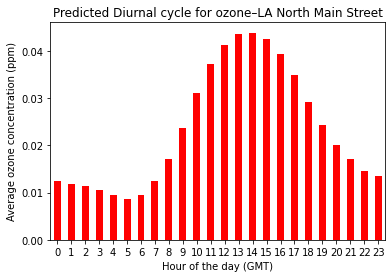

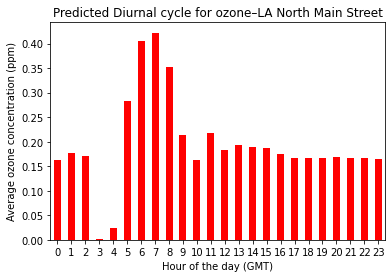

In [ ]:
times = ozone_predicted['timestamp']
ozone_predicted_t = ozone_predicted.drop(['timestamp'], axis='columns')
ozone_predicted_s = ozone_predicted_t * scaling_factors_ozone
ozone_predicted = pd.concat([times, ozone_predicted_s], axis=1, join='outer')

plot_df = ozone_predicted.iloc[:-1460].groupby(ozone_predicted['timestamp'].dt.hour)['Ozone'].mean().plot(kind='bar', rot=0, color='red')
plt.xlabel('Hour of the day (GMT)')
plt.ylabel('Average ozone concentration (ppm)')
plt.title('Predicted Diurnal cycle for ozone–LA North Main Street')
plt.show()

plot_df = ozone_predicted.iloc[-1460:].groupby(ozone_predicted['timestamp'].dt.hour)['Ozone'].mean().plot(kind='bar', rot=0, color='red')
plt.xlabel('Hour of the day (GMT)')
plt.ylabel('Average ozone concentration (ppm)')
plt.title('Predicted Diurnal cycle for ozone–LA North Main Street')
plt.show()

This is probably where I'll stop. At least the CNN isn't outputting negative values anymore! Looks like the noralization helped a lot. I could certainly tune this further by adding more data and increasing the complexity of the model. Though I think for our current purposes, this should be a good enough deomnstration of naive data extrapoloation.

NOTE: For some reason this is broken again :/